In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime as dt
from tqdm import tqdm
import pandas as pd

In [2]:
ssts = xr.open_dataset('/mnt/c/Users/Bpara/Downloads/sst.mnmean.nc')
ssts = ssts.sel(time=ssts.time.dt.year>1949)

anomaly_months = [dt.datetime(1954, 9, 1), dt.datetime(1964, 1, 1), dt.datetime(1977, 2, 1), dt.datetime(1988, 8, 1), dt.datetime(2000, 2, 1), 
                dt.datetime(2006, 9, 1), dt.datetime(2012, 8, 1)]

#import sea surface temps from post 1950 via ersst
ssts

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 874, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-10-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2022-11-04

In [3]:
def month_avg(ssts, month):
    return ssts.sel(time=ssts.time.dt.month==month).mean(dim='time')

In [14]:
%%time
#it doesn't like it if I use a list comprehension for this, so good ole for loop & append is gonna have to do it
months_avg = None
ssts.load()
for year in range(1950, 2022):
    for month in range(1, 13):
        temp = ssts.sel(time=ssts.time.dt.month==month).mean(dim='time')
        temp = temp.expand_dims({'time': 1})
        temp = temp.assign_coords({'time': ('time', [dt.datetime(year, month, 1)])})
        if months_avg is not None:
            months_avg = xr.merge([months_avg, temp])
        else:
            months_avg = temp

CPU times: user 38.4 s, sys: 5.75 s, total: 44.2 s
Wall time: 56.7 s


In [15]:
months_avg

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 864, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

In [34]:
def month_anomaly_plot(ssts, year_month):
    
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
    
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
    im = ax.pcolor(ssts['lon']+180, ssts['lat'], ssts['sst'].sel(time=year_month)-month_avg(ssts, year_month.month)['sst'], 
                   alpha=0.75, cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(im)
    ax.set_title(f'''Sea surface temperature anomaly for {months[year_month.month]}, {year_month.year} \n
compared to 1950-2022 {months[year_month.month]} Average''')

In [35]:
sept_avg = month_avg(ssts, 9)
sept_avg

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (nbnds) float64 9.969e+36 9.969e+36
    sst        (lat, lon) float32 -1.8 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan

Text(0.5, 1.0, 'Sea surface temperature anomaly for September 1954 \ncompared to 1950-2022')

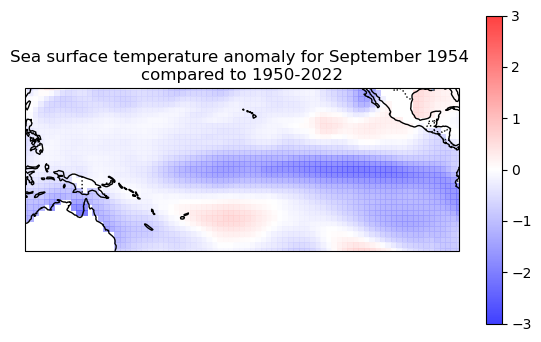

In [36]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], ssts['sst'].sel(time=dt.datetime(1954,9,1))-sept_avg['sst'], alpha=0.75, cmap='bwr', vmin=-3, vmax=3)
plt.colorbar(im)
ax.set_title('Sea surface temperature anomaly for September 1954 \ncompared to 1950-2022')

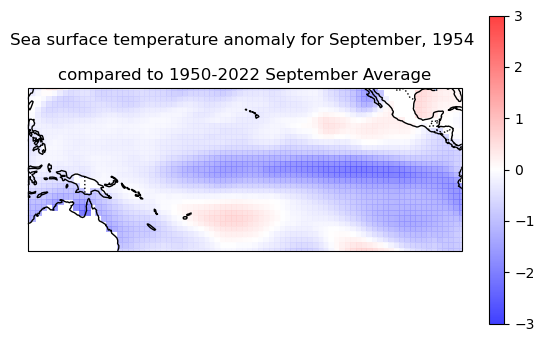

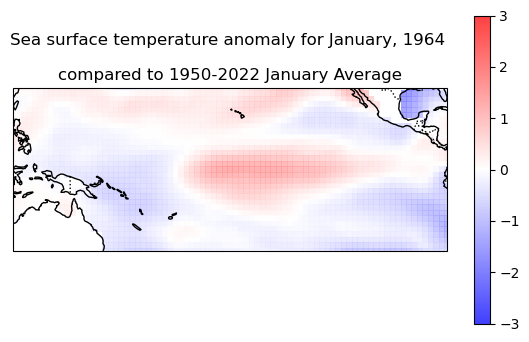

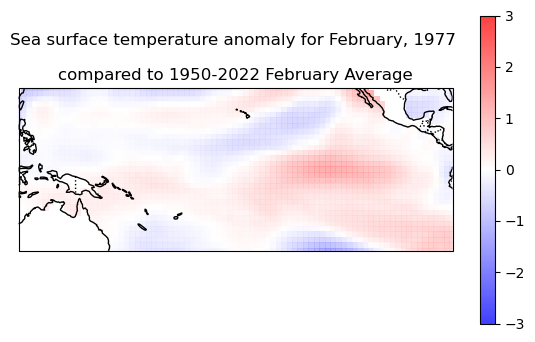

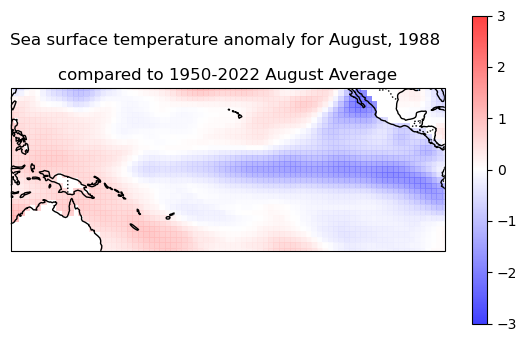

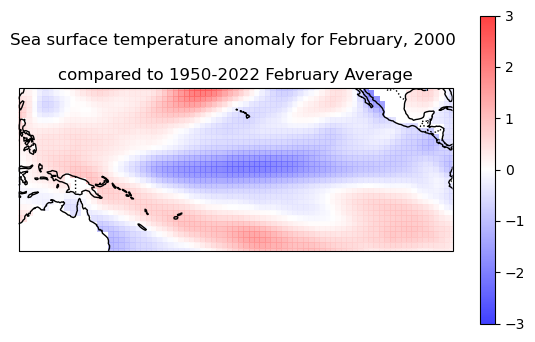

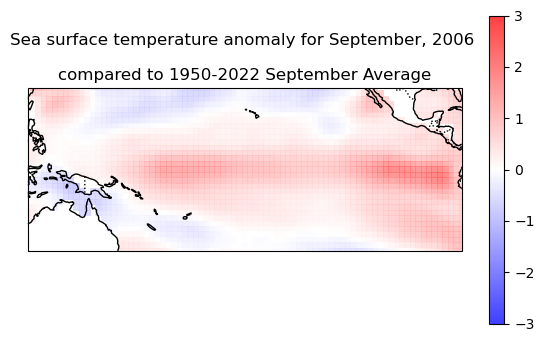

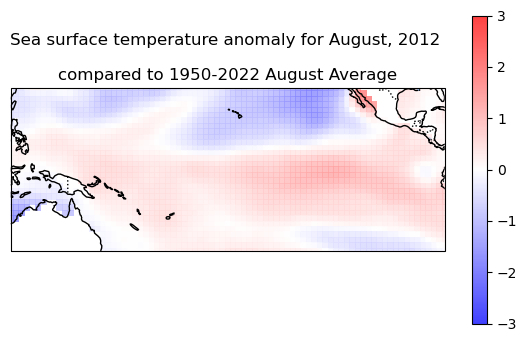

In [37]:
for anomaly in anomaly_months:
    month_anomaly_plot(ssts, anomaly)

In [38]:
mean_anomaly = 0
for anomaly in anomaly_months:
    mean_anomaly+=(ssts['sst'].sel(time=anomaly)-month_avg(ssts, anomaly.month)['sst'])/len(anomaly_months)

Text(0.5, 1.0, 'Average of all 7 low flow event Sea surface temperature \nanomaly')

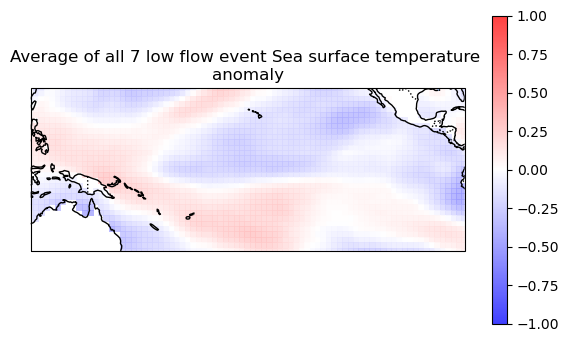

In [39]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
ax.set_extent([100, -60, 30, -30], crs=ccrs.PlateCarree(central_longitude=180))
im = ax.pcolor(ssts['lon']+180, ssts['lat'], mean_anomaly, alpha=0.75, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(im)
ax.set_title('Average of all 7 low flow event Sea surface temperature \nanomaly')

Theory: Each monthly SST anomaly pattern is being drawn from some theoretical distrubition of 2D SST anomaly patterns according to some probability distribution. We have N=72 draws for each month for 852 draws total, so if I draw M=50,000 864-size samples with replacement from each month and calculate the mean and standard deviation of the distribution of SST anomalies, I can find a bootstrapped estimate for the mean monthly anomaly and the standard deviation of said mean monthly anomaly. This assumes the monthly anomaly is being pulled from the same distribution each month however, which might be a point to revisit

In [40]:
def generate_months(num_months, year_min, year_max, month_min, month_max, random_seed=42):
    rng = np.random.default_rng(seed=random_seed)
    years = rng.integers(low=year_min, high=year_max, size=num_months)
    months = rng.integers(low=month_min, high=month_max, size=num_months)
    return [dt.datetime(year, month, 1) for year, month in zip(years, months)]

In [103]:
def bootstrap_ssts(ssts, months_avg, resample_size, num_resamples, lat_min=30, lon_min=120, lat_max=-30, lon_max=280, starting_random_seed=42, 
                   year_min=1950, year_max=2021, month_min=1, month_max=12,):
    
    bootstrap_sample = None
    
    for m in tqdm(range(num_resamples)):
        months = generate_months(resample_size, year_min, year_max, month_min, month_max, random_seed=starting_random_seed+m)
        resample_pull = (ssts.sel(time=months, lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)) - 
                         months_avg.sel(time=months, lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)))
        resample_mean = resample_pull.mean(dim='time')
        resample_mean = resample_mean.expand_dims({'pull_num': 1})
        resample_mean = resample_mean.assign_coords({'pull_num': ('pull_num', [m])})
        if bootstrap_sample is not None:
            bootstrap_sample = xr.merge([bootstrap_sample, resample_mean])
        else:
            bootstrap_sample = resample_mean
            
            
    return bootstrap_sample
        

In [104]:
%%time
mean = bootstrap_ssts(ssts, months_avg, 852, 50)
mean

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.25it/s]

CPU times: user 1.03 s, sys: 66.6 ms, total: 1.09 s
Wall time: 1.71 s


<xarray.Dataset>
Dimensions:    (lat: 31, lon: 81, pull_num: 50, nbnds: 2)
Coordinates:
  * lat        (lat) float32 30.0 28.0 26.0 24.0 ... -24.0 -26.0 -28.0 -30.0
  * lon        (lon) float32 120.0 122.0 124.0 126.0 ... 274.0 276.0 278.0 280.0
  * pull_num   (pull_num) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (pull_num, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sst        (pull_num, lat, lon) float32 nan 0.01222 ... 0.02475 0.02417

(array([ 3.,  4.,  8.,  6., 11.,  6.,  5.,  4.,  0.,  3.]),
 array([-0.03338718, -0.02151822, -0.00964925,  0.00221972,  0.01408868,
         0.02595765,  0.03782661,  0.04969558,  0.06156454,  0.0734335 ,
         0.08530247]),
 <BarContainer object of 10 artists>)

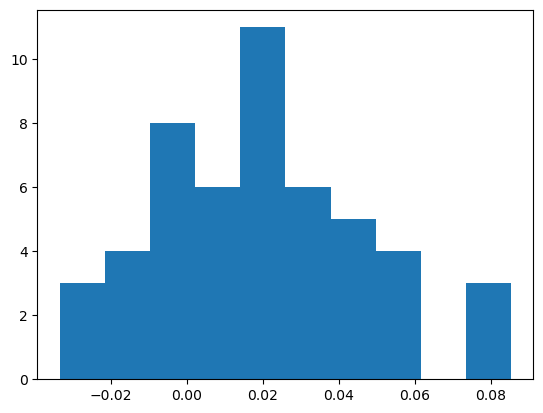

In [105]:
plt.hist(mean.sel(lat=0, lon=180)['sst'])

In [89]:
mean.sel(lat=0, lon=0)['sst']

<xarray.DataArray 'sst' (pull_num: 500)>
array([-0.02766034, -0.01841372, -0.05250612, -0.02794284, -0.0204956 ,
       -0.04389934,  0.00363217, -0.00843953, -0.03426358, -0.03655193,
       -0.02480724, -0.01776301, -0.01343938, -0.00258368,  0.02240562,
        0.00513923, -0.00502913, -0.00578816, -0.01330032, -0.02794147,
       -0.04224569, -0.0176727 , -0.01601901, -0.01689897,  0.0136035 ,
       -0.02486896, -0.04615026,  0.02156403, -0.03640166, -0.03970999,
        0.00078334, -0.02270331,  0.00606073,  0.00952138, -0.01383833,
       -0.02663153,  0.01373909, -0.02403513,  0.01568587, -0.02693105,
       -0.03867129, -0.01890578,  0.00764984,  0.00093846,  0.01289275,
       -0.02884965, -0.01686401,  0.0057158 , -0.02446677, -0.0408568 ,
       -0.02762749, -0.0057122 , -0.00484171, -0.01042673, -0.01151364,
       -0.01688178,  0.00051843, -0.00956462,  0.02733103, -0.05179562,
        0.00690755, -0.02325807, -0.0382507 , -0.03625157,  0.00569845,
       -0.00731439, -0.03310625, -0.04037632, -0.03196278, -0.03957856,
       -0.00339402, -0.03515776,  0.01040606, -0.0355942 , -0.01234113,
        0.00318492,  0.00686356,  0.0017063 , -0.02328694, -0.00619004,
       -0.05224217, -0.03449311,  0.00671108, -0.02183056, -0.02659567,
       -0.00638556, -0.04269383, -0.00924463, -0.04422623,  0.007865  ,
        0.01196253,  0.00113995, -0.01261024,  0.00563597, -0.02249425,
       -0.00490665,  0.01852687, -0.00234079, -0.00325369,  0.00608494,
...
       -0.01360687, -0.04019029, -0.01541865, -0.01397416, -0.00227193,
        0.002167  , -0.00432653, -0.02645918, -0.0446478 , -0.02307885,
       -0.01491875,  0.01236573, -0.0174388 , -0.04352237,  0.00575378,
       -0.01649963, -0.01956077, -0.00698113, -0.03573732, -0.01219892,
       -0.0698637 , -0.03160011, -0.0140981 , -0.04451187,  0.0297286 ,
       -0.00091027, -0.05626783,  0.01594972,  0.0097824 , -0.0076303 ,
       -0.00766142, -0.04550352, -0.01464583,  0.01955509,  0.01658596,
       -0.00436452,  0.0108472 , -0.03665885, -0.03575371, -0.02522088,
        0.01416709, -0.05181401, -0.00056874, -0.00249021, -0.02017706,
       -0.01466768, -0.00218724, -0.03801343,  0.02265538,  0.03050315,
       -0.02390179, -0.01387771,  0.00579506, -0.01001961, -0.043757  ,
       -0.00877512, -0.02017044, -0.01963698, -0.00755564, -0.02630447,
       -0.03047246, -0.00399675, -0.03464922,  0.01167159, -0.00183206,
        0.01367143,  0.00958678, -0.03187723, -0.02024154, -0.02673945,
       -0.0361075 ,  0.01269822,  0.01927952,  0.0047715 ,  0.00063637,
        0.01490027, -0.03027725, -0.00959212, -0.00682794, -0.01284356,
       -0.01116639, -0.04287323, -0.03066543, -0.03323923, -0.01949432,
        0.01670823, -0.01264187, -0.03073666, -0.04266451, -0.01544551,
       -0.0118578 , -0.02357748, -0.00018675,  0.00686949, -0.00243238],
      dtype=float32)
Coordinates:
    lat       float32 0.0
    lon       float32 0.0
  * pull_num  (pull_num) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [ ]:
ds

In [ ]:
ds.sel(time = [1, 3, 5, 1, 3, 1, 6, 10, 0, 9, 9, 10, 6, 9, 2, 1])

In [ ]:
month_avg(ssts, 1)

In [74]:
ssts.sel(time = dt.datetime(1980, 6, 1,)) - months_avg.sel(time = dt.datetime(1980, 6, 1,))

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    time       datetime64[ns] 1980-06-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (nbnds) float64 0.0 0.0
    sst        (lat, lon) float32 1.192e-06 1.192e-06 1.192e-06 ... nan nan nan